# Fermi-Hubbard model (H=A+B+C)

The one-dimensional Fermi-Hubbard Hamiltonian

$$
H = - J \sum_{j = 1}^{L - 1} \sum_{\sigma \in \{ \uparrow, \downarrow \}} c_{j, \sigma}^\dagger c_{j + 1, \sigma} + \text{h.c.} + U \sum_{j} n_{j\uparrow} n_{j\downarrow}
$$

where $j = 1, ..., L$ denotes site/orbital and $\sigma \in \{ \uparrow, \downarrow \}$ denotes spin. 

In [1]:
import numpy as np
from scipy.linalg import expm

from trotter import *
# from lattice_hamiltonians import interference_bound, tight_bound
from lattice_hamiltonians import hubbard_openfermion, data_plot
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d, Power_Law
from plot_config import *

# mpl.rcParams['lines.markersize'] = 12

fig_dir, data_dir = './figs', './data'

from colorspace import qualitative_hcl, swatchplot
pal = qualitative_hcl("Dark 2")  # Dynamic
cc = [c+'FF' for c in pal(5)]  # Draw list of 4 colors across the palette
# print('color_cycle: ', cc)
# ['#C87A8AFF', '#A29048FF', '#45A271FF', '#2A9EB5FF', '#A782C3FF']
# set_color_cycle(cc)

## Three groups: commutation relation

one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
one_body_L:  6
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)
bi_group_01: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
bi_group_23: 
 [-1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3]]
tri_group_0: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [3^ 5] +
-1.0 [5^ 3]]
tri_group_1: 
 [-1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [4^ 6] +
-1.0 [6^ 4]]
tri_group_2: 
 [-1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [5^ 7] +
-1.0 [7^ 5]]
(256, 256)
(256, 256)
(256, 256)


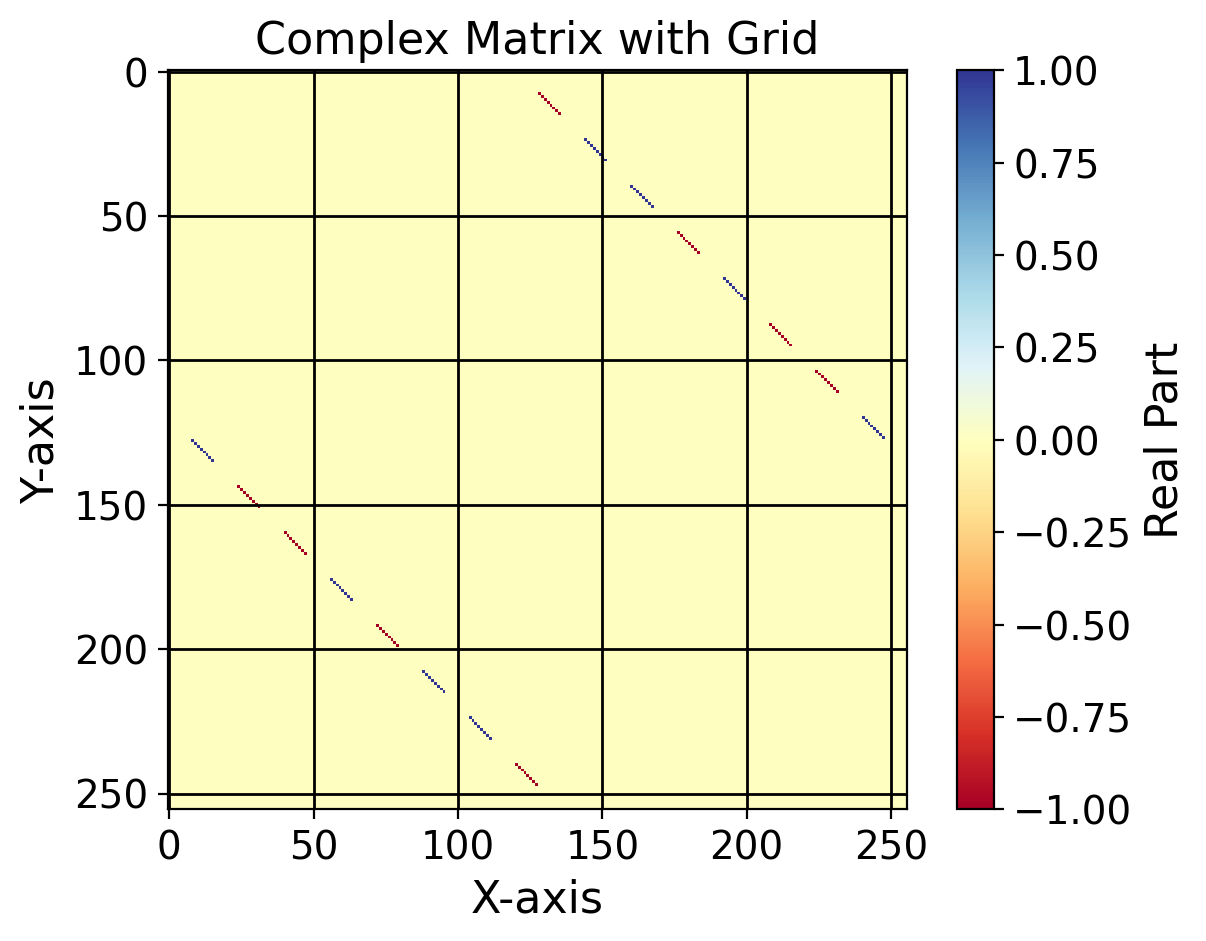

In [2]:
## parameters of Hubbard Hamiltonian and evolution
n = 4
t = n * 5
epsilon = 1e-3
J = -1
hubbard = hubbard_openfermion(n, J, verbose=True)
print('bi_group_01: \n', hubbard.one_body_01)
print('bi_group_23: \n', hubbard.one_body_23)
print('tri_group_0: \n', hubbard.one_body_0)
print('tri_group_1: \n', hubbard.one_body_1)
print('tri_group_2: \n', hubbard.one_body_2)
# print('commutator: ', commutator(hubbard.one_body_sparse[5], hubbard.one_body_sparse[9]))

## binary grouping
bi_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse)]
# print(bi_group)
## triple grouping
tri_group = [sum(hubbard.one_body_0_sparse), sum(hubbard.one_body_1_sparse), sum(hubbard.one_body_2_sparse)]
for item in tri_group:
    print(item.shape)

hubbard.two_body_fops
hubbard.two_body_sparse
# matrix_plot(hubbard.one_body_01_sparse[0])
matrix_plot(commutator(hubbard.one_body_sparse[0], hubbard.one_body_sparse[2]))
# matrix_plot(commutator(hubbard.two_body_sparse[3], hubbard.one_body_sparse[2]))
print(f'commutator: {norm(commutator(hubbard.one_body_01_sparse[0], hubbard.two_body_sparse[1]))}')
# hubbard.one_body_0

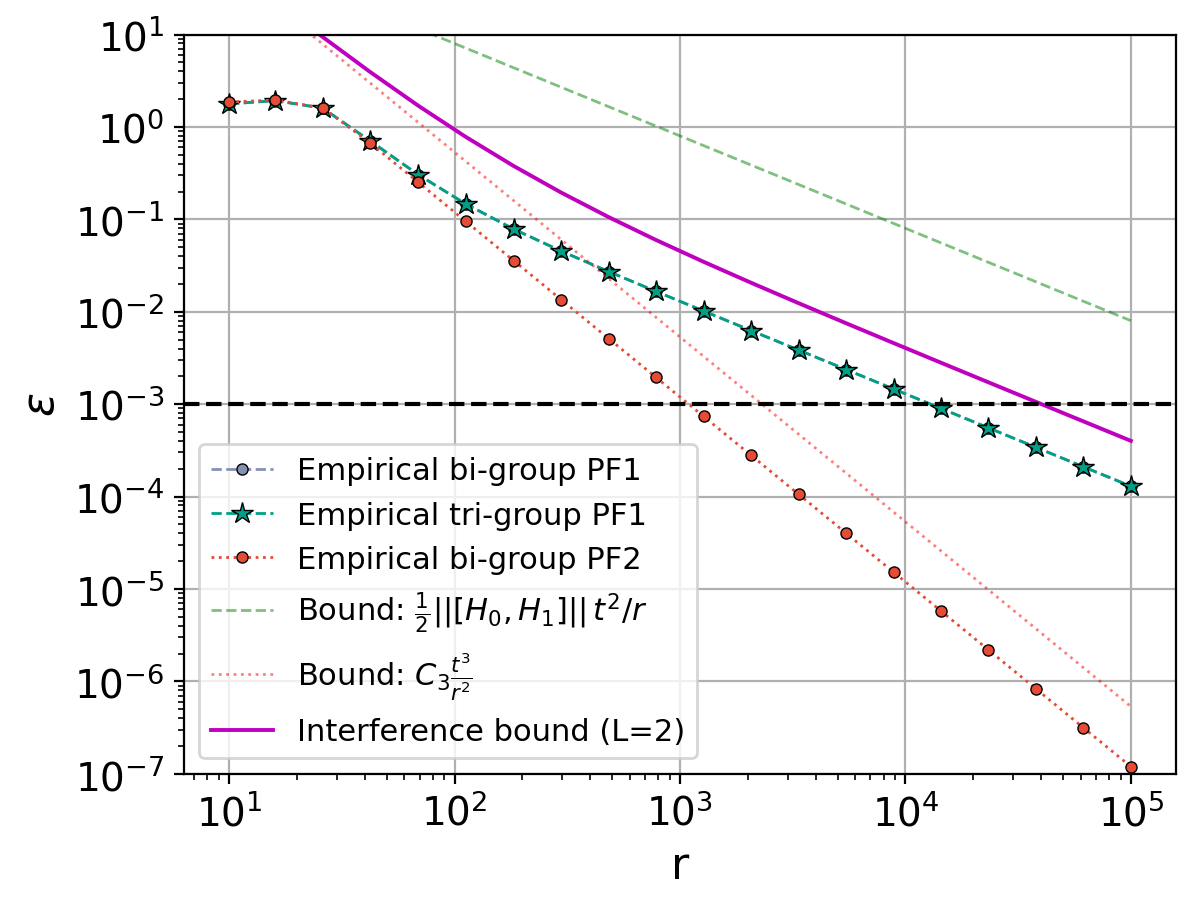

In [3]:
r_list = np.logspace(1, 5, num=20, dtype=int)
exact_U = expm(-1j * t * sum(bi_group))

## empirical PF1 and PF2
pf1_bi_list = [op_error(matrix_power(unitary_matrix_product(bi_group, t=t/r), r), exact_U) for r in r_list]
pf2_bi_list = [op_error(matrix_power(unitary_matrix_product(bi_group, t=t/(2*r)) @ unitary_matrix_product(bi_group[::-1], t=t/(2*r)), r), exact_U) for r in r_list]

pf1_tri_list = [op_error(matrix_power(unitary_matrix_product(tri_group, t=t/r), r), exact_U) for r in r_list]

## interference bound
bound = [interference_bound(bi_group, t, r)[0] for r in r_list]
e1 = np.array([interference_bound(bi_group, t, r)[1] for r in r_list])
e2 = np.array([interference_bound(bi_group, t, r)[2] for r in r_list])
e3 = np.array([interference_bound(bi_group, t, r)[3] for r in r_list])

data_plot(r_list, pf1_bi_list, '.--', label= 'Empirical bi-group PF1')
data_plot(r_list, pf1_tri_list, '*--', label= 'Empirical tri-group PF1')
data_plot(r_list, pf2_bi_list, '.:', label= 'Empirical bi-group PF2')
# data_plot(r_list, e1, 'y--', alpha=0.5, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
data_plot(r_list, e2, 'g--', alpha=0.5, label=r'Bound: $\frac{1}{2}||[H_0,H_1]||\, t^2/r$', linewidth=1) # C_2
data_plot(r_list, e3, 'r:', alpha=0.5, label=r'Bound: $C_3\frac{t^3}{r^2}$', linewidth=1)
data_plot(r_list, bound, 'm-', linewidth=1.4, label=r'Interference bound (L=2)')

# plot results bounds and empirical PF1 and PF2
plt.axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('r')
plt.ylim(1e-7, 1e1)
plt.ylabel(r'$\epsilon$')
# plt.title(rf'(Fermi-Hubbard, n={n}, t={t}, J={J})')
plt.legend(fontsize=11, loc='lower left')
# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig(f'./figs/hubbard_interference_n={n}_t={t}_J={J}.pdf', bbox_inches='tight')

## Fixed r, change t

In [5]:
n = 4
r = 10000
epsilon = 1e-3
J, U = -1, 1

t_list = np.logspace(1.5, 3, num=200)
hubbard = hubbard_openfermion(n, U, verbose=True)
h_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse), sum(hubbard.two_body_sparse)]
exact_U_list = [expm(-1j * t * sum(h_group)) for t in t_list]
# pf1_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/r), r), exact_U_list[i]) for i, t in enumerate(t_list)]
emp_pf1_list = [norm(pf_r(h_group, t, r, order=1)-exact_U_list[i]) for i, t in enumerate(t_list)]
emp_pf2_list = [norm(pf_r(h_group, t, r, order=2)-exact_U_list[i]) for i, t in enumerate(t_list)]

bnd_pf1_tight_tri = np.array([tight_bound(h_group, 1, t, r) for t in t_list])
bnd_pf2_tight_tri = np.array([tight_bound(h_group, 2, t, r) for t in t_list])
# interf_bound = np.array([interference_bound(bi_group, t, r) for t in t_list])

one_body_terms: 
 [-1.0 [0^ 2] +
-1.0 [2^ 0], -1.0 [1^ 3] +
-1.0 [3^ 1], -1.0 [2^ 4] +
-1.0 [4^ 2], -1.0 [3^ 5] +
-1.0 [5^ 3], -1.0 [4^ 6] +
-1.0 [6^ 4], -1.0 [5^ 7] +
-1.0 [7^ 5]]
one_body_L:  6
one_body[0]: 
   (4, 1)	(-1+0j)
  (6, 3)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)


Slope (a): 1.111574087055801 ; Intercept (b): -9.013150970823762
Slope (a): 2.9479264178000597 ; Intercept (b): -19.331601528760267
Slope (a): 2.0 ; Intercept (b): -8.035981366356634
title: <<Tri-group (Fermi-Hubbard, n=4, r=10000)>>


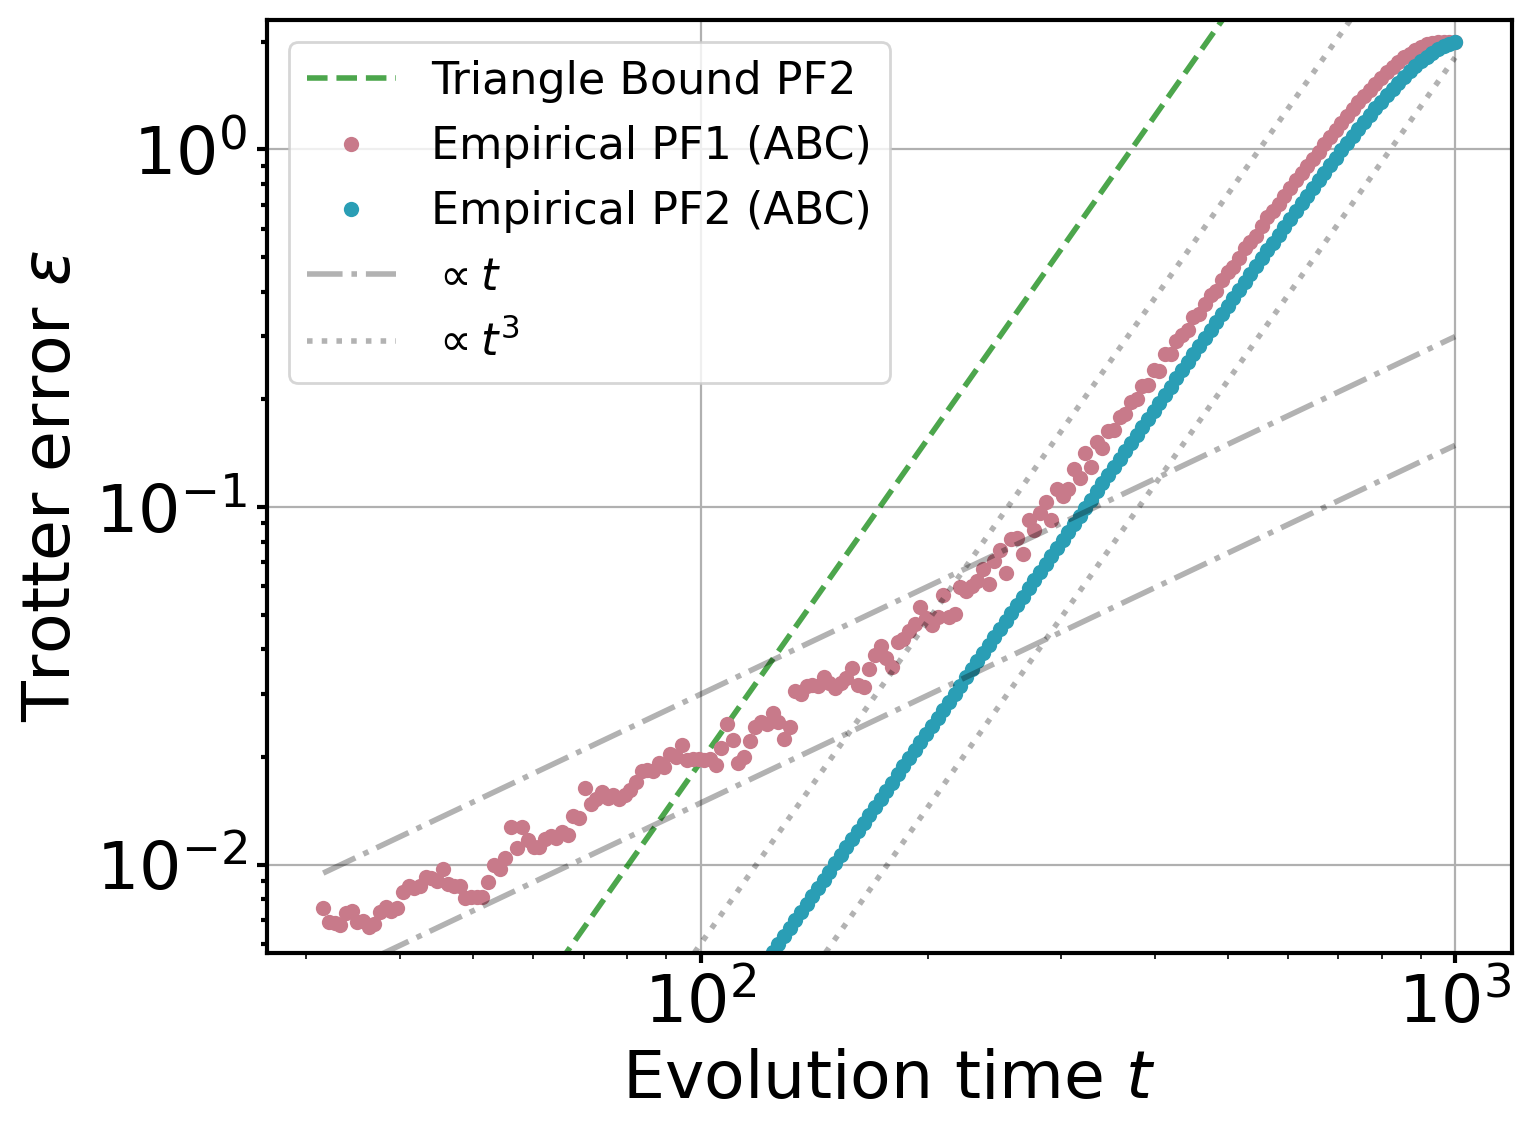

In [23]:
prefix, suffix = 'Hubbard', 'Tri'
# set_color_cycle(cc, alpha=0.05)
# plt.rc('legend', fontsize=MEDIUM_SIZE-2) 
start1, end1 = int(1*len(t_list)/10), int(4*len(t_list)/10)
start2, end2 = int(7*len(t_list)/10), int(9*len(t_list)/10)
_, a_1, b_1 = linear_loglog_fit(t_list[start1:end1], emp_pf1_list[start1:end1], verbose=True)
_, a_2, b_2 = linear_loglog_fit(t_list[start2:end2], emp_pf2_list[start2:end2], verbose=True)
_, a_bnd, b_bnd = linear_loglog_fit(t_list, bnd_pf1_tight_tri, verbose=True)

# set_color_cycle(cc, 0.1)
fig, ax = plt.subplots(1, 1)
ax.plot(t_list, bnd_pf2_tight_tri, 'g--', alpha=0.7, label=r'Triangle Bound PF2', linewidth=2)
ax.plot(t_list, emp_pf1_list, '.', label= 'Empirical PF1 (ABC)', mfc='#C87A8AFF', markeredgewidth=0.0)
ax.plot(t_list, emp_pf2_list, '.', label= 'Empirical PF2 (ABC)', mfc='#2A9EB5FF', markeredgewidth=0.0)
# r_list, e1, 'y--', alpha=0.5, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
# ax.plot(t_list, e_pf1_tight_tri, 'r-', alpha=0.5, label=r'Triangle Bound PF1', linewidth=1.5) # C_2
ax.plot(t_list, [t*exp(b_1+0.9) for t in t_list], 'k-.', linewidth=2, alpha=0.3, label=fr'$\propto t$')
ax.plot(t_list, [t*exp(b_1+0.2) for t in t_list], 'k-.', linewidth=2, alpha=0.3)
# ax.plot(t_list, [t**2*exp(b_bnd+0.5) for t in t_list], 'k--', linewidth=2, alpha=0.3, label=fr'$\propto t^2$')
# ax.plot(t_list, [t**2*exp(b_bnd-0.5) for t in t_list], 'k--', linewidth=2, alpha=0.3)
ax.plot(t_list, [t**3*exp(b_2+0.4) for t in t_list], 'k:', linewidth=2, alpha=0.3, label=fr'$\propto t^3$')
ax.plot(t_list, [t**3*exp(b_2-0.8) for t in t_list], 'k:', linewidth=2, alpha=0.3)
ax_set_text(ax, r'Evolution time $t$', r'Trotter error $\epsilon$', log='xy', ylim=[min(emp_pf1_list), max(emp_pf1_list)])  # ax.grid()
title = rf'Tri-group (Fermi-Hubbard, n={n}, r={r})'
print(f'title: <<{title}>>')
# ax.set_title(title)
fig.savefig(f'{fig_dir}/{prefix}_n={n}_r={r}_{suffix}.pdf')

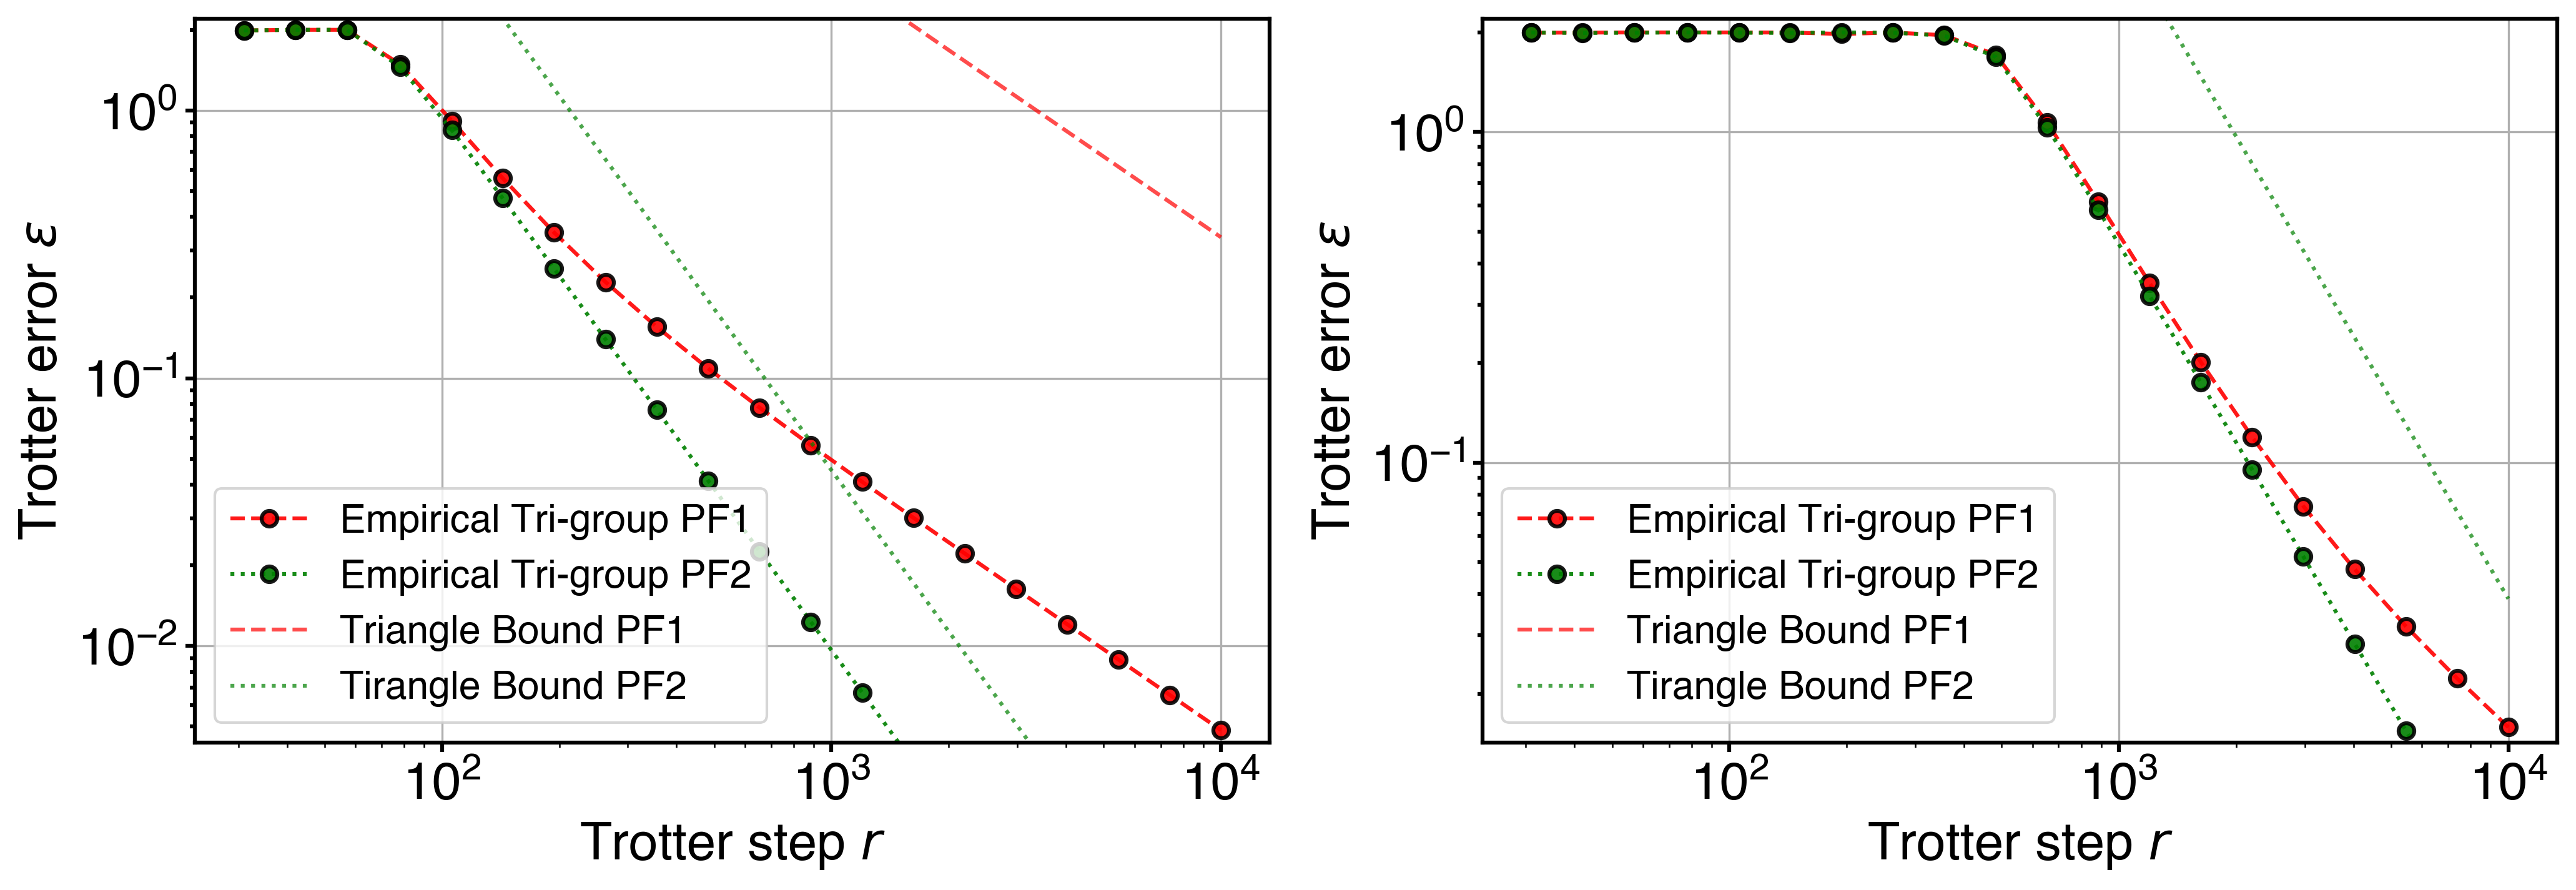

In [13]:
## parameters of Hubbard Hamiltonian and evolution
n = 4
t = n * 10
# r = 10000
epsilon = 1e-3
J = -1
# U = 10*J

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, U in enumerate([0.1, 10]):
    hubbard = hubbard_openfermion(n, U, verbose=False)

    r_list = np.logspace(1.5, 4, num=20, dtype=int)
    # t_list = np.logspace(1, 3, num=20, dtype=int)
    h_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse), sum(hubbard.two_body_sparse)]
    # exact_U = expm(-1j * t * sum(h_group))

    ## empirical PF1 and PF2
    pf1_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/r), r), expm(-1j * t * sum(h_group))) for r in r_list]
    pf2_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/(2*r)) @ unitary_matrix_product(h_group[::-1], t=t/(2*r)), r), expm(-1j * t * sum(h_group))) for r in r_list]

    e_pf1_tight_tri = np.array([tight_bound(h_group, 1, t, r) for r in r_list])
    e_pf2_tight_tri = np.array([tight_bound(h_group, 2, t, r) for r in r_list])

    axes[i].plot(r_list, pf1_list, 'r.--', label= 'Empirical Tri-group PF1')
    axes[i].plot(r_list, pf2_list, 'g.:', label= 'Empirical Tri-group PF2')
    # r_list, e1, 'y--', alpha=0.5, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
    axes[i].plot(r_list, e_pf1_tight_tri, 'r--', alpha=0.7, label=r'Triangle Bound PF1') # C_2
    axes[i].plot(r_list, e_pf2_tight_tri, 'g:', alpha=0.7, label=r'Tirangle Bound PF2')

    # plot results bounds and empirical PF1 and PF2
    axes[i].axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
    ax_set_text(axes[i], r'Trotter step $r$', r'Trotter error $\epsilon$', log='xy', ylim=[min(pf1_list), max(pf1_list)])
    # axes[i].set_title(rf'(Fermi-Hubbard, n={n}, t={t}, J={J})')

# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# fig.savefig(f'{fig_dir}/hubbard_interference_n={n}_t={t}.pdf', bbox_inches='tight')

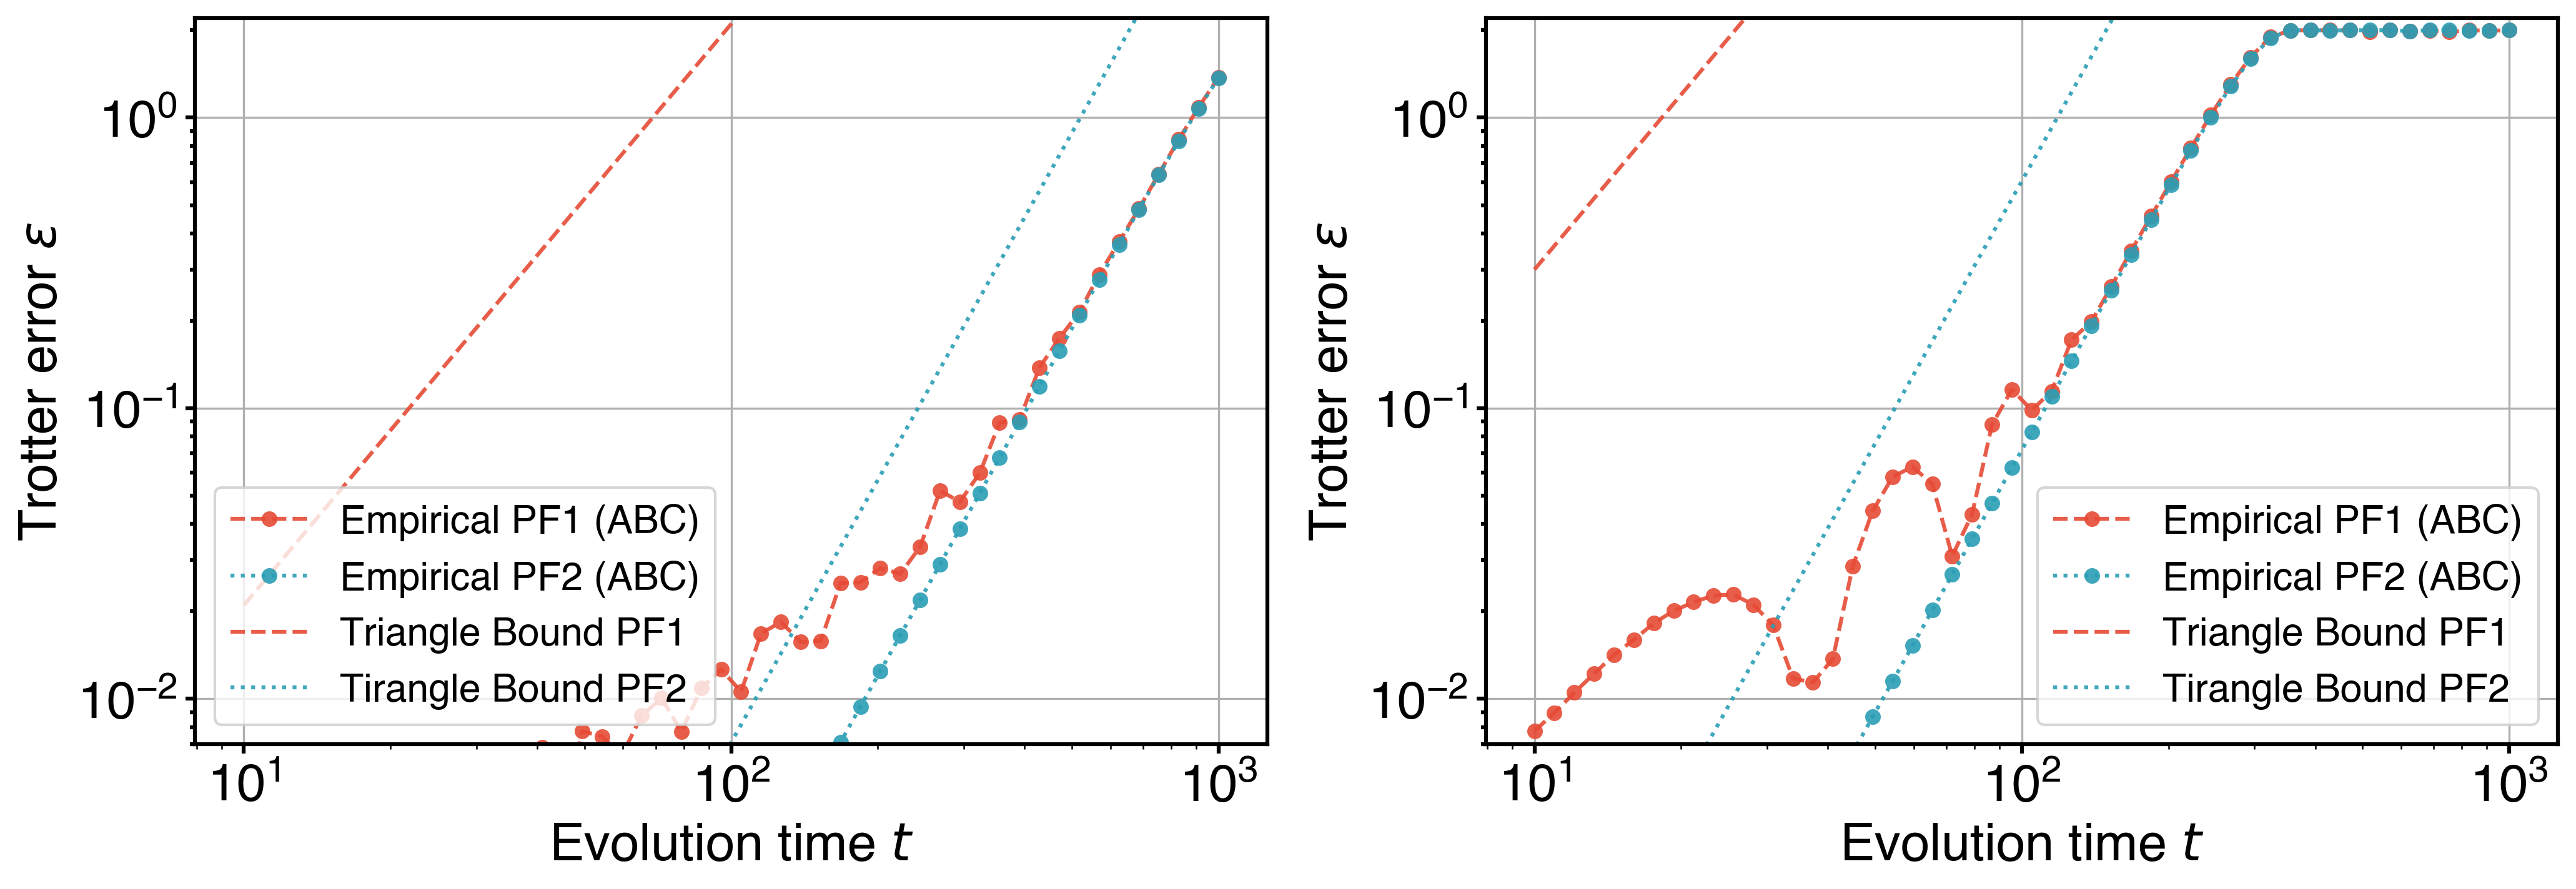

In [21]:
## parameters of Hubbard Hamiltonian and evolution
n = 4
# t = n * 1
r = 10000
epsilon = 1e-3
J = -1  # U = 10*J
U_list = [0.1, 10]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, U in enumerate(U_list):
    hubbard = hubbard_openfermion(n, U, verbose=False)

    # r_list = np.logspace(1, 5, num=20, dtype=int)
    t_list = np.logspace(1, 3, num=50)
    h_group = [sum(hubbard.one_body_01_sparse), sum(hubbard.one_body_23_sparse), sum(hubbard.two_body_sparse)]
    # exact_U = expm(-1j * t * sum(h_group))

    ## empirical PF1 and PF2
    exact_U_list = [expm(-1j * t * sum(h_group)) for t in t_list]
    # pf1_list = [op_error(matrix_power(unitary_matrix_product(h_group, t=t/r), r), exact_U_list[i]) for i, t in enumerate(t_list)]
    emp_pf1_list = [norm(pf_r(h_group, t, r, order=1)-exact_U_list[i]) for i, t in enumerate(t_list)]
    emp_pf2_list = [norm(pf_r(h_group, t, r, order=2)-exact_U_list[i]) for i, t in enumerate(t_list)]

    bnd_pf1_tight = np.array([tight_bound(h_group, 1, t, r) for t in t_list])
    bnd_pf2_tight = np.array([tight_bound(h_group, 2, t, r) for t in t_list])

    axes[i].plot(t_list, emp_pf1_list, '.--', label='Empirical PF1 (ABC)', c='#E64B35FF',markeredgewidth=0)
    axes[i].plot(t_list, emp_pf2_list, '.:', label='Empirical PF2 (ABC)', c='#2A9EB5FF', markeredgewidth=0)
    # r_list, e1, 'y--', alpha=0.5, label=r'Bound: $\min(||H_0||,||H_1||)\, t/r$', linewidth=1) # C_1
    axes[i].plot(t_list, bnd_pf1_tight, '--', label=r'Triangle Bound PF1', c='#E64B35FF') # C_2
    axes[i].plot(t_list, bnd_pf2_tight, ':', label=r'Tirangle Bound PF2', c='#2A9EB5FF')

    # plot results bounds and empirical PF1 and PF2
    axes[i].axhline(y=epsilon, c='k', linestyle='--', linewidth=1.5)
    ax_set_text(axes[i], r'Evolution time $t$', r'Trotter error $\epsilon$', log='xy', ylim=[min(pf1_list), max(pf1_list)])

# plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# fig.savefig(f'./figs/hubbard_interference_n={n}_r={r}.pdf', bbox_inches='tight')

<!-- ### Trotterization
### Preparing the initial state
#### Compare to direct diagonalization

### Computing the time-evolved charge and spin density
### Computing the charge and spin spread -->

In [ ]:
# try:
#     import openfermion
# except ImportError:
#     !pip install git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion